# Machine Learning

In this file, instructions how to approach the challenge can be found.

We are going to work on different types of Machine Learning problems:

- **Regression Problem**: The goal is to predict delay of flights.
- **(Stretch) Multiclass Classification**: If the plane was delayed, we will predict what type of delay it is (will be).
- **(Stretch) Binary Classification**: The goal is to predict if the flight will be cancelled.

In [86]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import scipy.stats as stats
import numpy as np


In [87]:

import plotly.express as px
import plotly.graph_objs as go
from sklearn.preprocessing import MinMaxScaler

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold

In [88]:
# Importing the saved CSV file into dataframe 
# Imported this dataframe that was created in our EDA notebook
flights_df = pd.read_csv("/Users/ckz/Desktop/DATA_SCIENCE_BOOTCAMP/Midterm-project/flights_df.csv")

# print the first few rows of the DataFrame
flights_df.head()

,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin,...,first_dep_time,total_add_gtime,longest_add_gtime,no_name,month,dep_hour,arr_hour,taxi_time,origin_state,flight_distance_category
0,2018-01-01,B6,B6,B6,880,B6,N794JB,880,12954,LGB,...,NaN,NaN,NaN,NaN,1,7,8,83.0,CA,SHORT
1,2018-01-01,B6,B6,B6,885,B6,N337JB,885,12478,JFK,...,NaN,NaN,NaN,NaN,1,7,9,120.0,NY,SHORT
2,2018-01-01,B6,B6,B6,886,B6,N337JB,886,14492,RDU,...,NaN,NaN,NaN,NaN,1,10,11,102.0,NC,SHORT
3,2018-01-01,B6,B6,B6,889,B6,N318JB,889,11278,DCA,...,NaN,NaN,NaN,NaN,1,18,19,162.0,DC,SHORT
4,2018-01-01,B6,B6,B6,891,B6,N348JB,891,10721,BOS,...,NaN,NaN,NaN,NaN,1,6,9,317.0,MA,MEDIUM


In [90]:
flights_df.shape

(1559045, 48)

In [91]:
# # Shuffle the data in the DataFrame and create a sample with half the size
sample_size = len(flights_df) // 10

flights_sample = flights_df.sample(n=sample_size, random_state=42)

## Reset the index of the shuffled sample

flights_sample.reset_index(drop=True, inplace=True)

In [92]:
flights_sample.shape

(155904, 48)

## Main Task: Regression Problem

The target variable is **ARR_DELAY**. We need to be careful which columns to use and which don't. For example, DEP_DELAY is going to be the perfect predictor, but we can't use it because in real-life scenario, we want to predict the delay before the flight takes of --> We can use average delay from earlier days but not the one from the actual flight we predict.  

For example, variables **CARRIER_DELAY, WEATHER_DELAY, NAS_DELAY, SECURITY_DELAY, LATE_AIRCRAFT_DELAY** shouldn't be used directly as predictors as well. However, we can create various transformations from earlier values.

We will be evaluating your models by predicting the ARR_DELAY for all flights **1 week in advance**.

In [93]:
flights_sample.columns.tolist()

['fl_date',
 'mkt_unique_carrier',
 'branded_code_share',
 'mkt_carrier',
 'mkt_carrier_fl_num',
 'op_unique_carrier',
 'tail_num',
 'op_carrier_fl_num',
 'origin_airport_id',
 'origin',
 'origin_city_name',
 'dest_airport_id',
 'dest',
 'dest_city_name',
 'crs_dep_time',
 'dep_time',
 'dep_delay',
 'taxi_out',
 'wheels_off',
 'wheels_on',
 'taxi_in',
 'crs_arr_time',
 'arr_time',
 'arr_delay',
 'cancelled',
 'cancellation_code',
 'diverted',
 'dup',
 'crs_elapsed_time',
 'actual_elapsed_time',
 'air_time',
 'flights',
 'distance',
 'carrier_delay',
 'weather_delay',
 'nas_delay',
 'security_delay',
 'late_aircraft_delay',
 'first_dep_time',
 'total_add_gtime',
 'longest_add_gtime',
 'no_name',
 'month',
 'dep_hour',
 'arr_hour',
 'taxi_time',
 'origin_state',
 'flight_distance_category']

In [94]:
flights_df.shape

(1559045, 48)

### Feature Engineering

Feature engineering will play a crucial role in this problems. We have only very little attributes so we need to create some features that will have some predictive power.

- weather: we can use some weather API to look for the weather in time of the scheduled departure and scheduled arrival.
- statistics (avg, mean, median, std, min, max...): we can take a look at previous delays and compute descriptive statistics
- airports encoding: we need to think about what to do with the airports and other categorical variables
- time of the day: the delay probably depends on the airport traffic which varies during the day.
- airport traffic
- unsupervised learning as feature engineering?
- **what are the additional options?**: Think about what we could do more to improve the model.

In [95]:
flights_df['avg_monthly_arr_delay'] = flights_df.groupby('month')['arr_delay'].transform('mean')

In [96]:
flights_df.isnull().sum()

fl_date                           0
mkt_unique_carrier                0
branded_code_share                0
mkt_carrier                       0
mkt_carrier_fl_num                0
op_unique_carrier                 0
tail_num                          0
op_carrier_fl_num                 0
origin_airport_id                 0
origin                            0
origin_city_name                  0
dest_airport_id                   0
dest                              0
dest_city_name                    0
crs_dep_time                      0
dep_time                          0
dep_delay                         0
taxi_out                          0
wheels_off                        0
wheels_on                         0
taxi_in                           0
crs_arr_time                      0
arr_time                          0
arr_delay                         0
cancelled                         0
cancellation_code           1559045
diverted                          0
dup                         

In [97]:
# This feature creates the avg taxi times for the arrival hour 
flights_df['avg_taxi_times_arr'] = flights_df.groupby('arr_hour')['taxi_time'].transform('mean')

In [98]:
flights_df.shape

(1559045, 50)

In [99]:
flights_df['fl_date'].dtype

dtype('O')

In [100]:
# Group the flights data by origin airport and count the number of flights for each airport
airport_counts = flights_df.groupby('origin')['flights'].transform('count')

# Determine the thresholds for each category based on the quartiles
thresholds = [0, airport_counts.quantile(0.25), airport_counts.quantile(0.5), airport_counts.quantile(0.75), np.inf]

# Define the categories
categories = ['Not Busy', 'Moderate', 'Busy', 'Very Busy']

# Assign the traffic category based on the number of flights from each airport
flights_df['traffic'] = pd.cut(airport_counts, bins=thresholds, labels=categories, right=False)

In [101]:
flights_df['traffic'].isnull().sum()

0

In [102]:
flights_df.tail(20)

,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin,...,no_name,month,dep_hour,arr_hour,taxi_time,origin_state,flight_distance_category,avg_monthly_arr_delay,avg_taxi_times_arr,traffic
1559025,2019-07-31,DL,DL,DL,2882,DL,N377DE,2882,14570,RNO,...,NaN,7,6,8,200.0,NV,SHORT,9.147818,126.377344,Not Busy
1559026,2019-07-31,DL,DL,DL,2883,DL,N815DN,2883,10299,ANC,...,NaN,7,7,12,399.0,AK,MEDIUM,9.147818,159.242403,Not Busy
1559027,2019-07-31,DL,DL,DL,2885,DL,N356NW,2885,10423,AUS,...,NaN,7,6,8,193.0,TX,LONG,9.147818,126.377344,Moderate
1559028,2019-07-31,DL,DL,DL,2886,DL,N372DA,2886,10693,BNA,...,NaN,7,6,9,275.0,TN,LONG,9.147818,146.300733,Moderate
1559029,2019-07-31,DL,DL,DL,2887,DL,N717JL,2887,11292,DEN,...,NaN,7,14,16,173.0,CO,MEDIUM,9.147818,188.762904,Very Busy
1559030,2019-07-31,DL,DL,DL,2888,DL,N336NB,2888,10423,AUS,...,NaN,7,8,10,122.0,TX,MEDIUM,9.147818,154.643609,Moderate
1559031,2019-07-31,DL,DL,DL,2889,DL,N3749D,2889,14869,SLC,...,NaN,7,20,21,41.0,UT,MEDIUM,9.147818,150.908933,Moderate
1559032,2019-07-31,DL,DL,DL,2890,DL,N967DL,2890,10397,ATL,...,NaN,7,22,22,-13.0,GA,SHORT,9.147818,101.631200,Very Busy
1559033,2019-07-31,DL,DL,DL,2891,DL,N3751B,2891,15304,TPA,...,NaN,7,12,14,178.0,FL,MEDIUM,9.147818,178.305499,Moderate
1559034,2019-07-31,DL,DL,DL,2892,DL,N910DL,2892,13244,MEM,...,NaN,7,7,9,194.0,TN,SHORT,9.147818,146.300733,Not Busy


In [103]:
states = {
        'AK': 'O',
        'AL': 'S',
        'AR': 'S',
        'AS': 'O',
        'AZ': 'W',
        'CA': 'W',
        'CO': 'W',
        'CT': 'N',
        'DC': 'N',
        'DE': 'N',
        'FL': 'S',
        'GA': 'S',
        'GU': 'O',
        'HI': 'O',
        'IA': 'M',
        'ID': 'W',
        'IL': 'M',
        'IN': 'M',
        'KS': 'M',
        'KY': 'S',
        'LA': 'S',
        'MA': 'N',
        'MD': 'N',
        'ME': 'N',
        'MI': 'W',
        'MN': 'M',
        'MO': 'M',
        'MP': 'O',
        'MS': 'S',
        'MT': 'W',
        'NA': 'O',
        'NC': 'S',
        'ND': 'M',
        'NE': 'W',
        'NH': 'N',
        'NJ': 'N',
        'NM': 'W',
        'NV': 'W',
        'NY': 'N',
        'OH': 'M',
        'OK': 'S',
        'OR': 'W',
        'PA': 'N',
        'PR': 'O',
        'RI': 'N',
        'SC': 'S',
        'SD': 'M',
        'TN': 'S',
        'TX': 'S',
        'UT': 'W',
        'VA': 'S',
        'VI': 'O',
        'VT': 'N',
        'WA': 'W',
        'WI': 'M',
        'WV': 'S',
        'WY': 'W'
}

region_mapping = {
    'O': 'Other',
    'S': 'South',
    'W': 'West',
    'N': 'North',
    'M': 'Midwest'
}

# Clean the 'state_code' values by converting to strings and removing leading/trailing whitespaces
flights_df['orgin_state'] = flights_df['origin_state'].astype(str).str.strip()

# Create a new column 'Region' based on the mapping
flights_df['Region'] = flights_df['origin_state'].map(states).map(region_mapping)

In [104]:
from pandas.tseries.holiday import USFederalHolidayCalendar as holiday_calendar

In [105]:
from datetime import datetime

In [106]:
flights_df['fl_date'] = flights_df['fl_date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))

In [107]:
# holiday_cal
cal = holiday_calendar()
dr = flights_df['fl_date'] 
holidays = cal.holidays(start=dr.min(), end=dr.max())
flights_df['holiday'] = flights_df['fl_date'].dt.date.astype('datetime64').isin(holidays).astype(int)
flights_df.tail(5)

,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin,...,arr_hour,taxi_time,origin_state,flight_distance_category,avg_monthly_arr_delay,avg_taxi_times_arr,traffic,orgin_state,Region,holiday
1559040,2019-07-31,DL,DL,DL,2899,DL,N932AT,2899,10397,ATL,...,17,114.0,GA,SHORT,9.147818,177.955554,Very Busy,GA,South,0
1559041,2019-07-31,DL,DL,DL,2899,DL,N932AT,2899,11057,CLT,...,18,83.0,NC,SHORT,9.147818,170.038468,Very Busy,NC,South,0
1559042,2019-07-31,DL,DL,DL,2900,DL,N301DQ,2900,10397,ATL,...,14,175.0,GA,MEDIUM,9.147818,178.305499,Very Busy,GA,South,0
1559043,2019-07-31,DL,DL,DL,2900,DL,N301DQ,2900,11624,EYW,...,17,126.0,FL,MEDIUM,9.147818,177.955554,Not Busy,FL,South,0
1559044,2019-07-31,DL,DL,DL,2901,DL,N397DA,2901,11292,DEN,...,9,159.0,CO,SHORT,9.147818,146.300733,Very Busy,CO,West,0


In [108]:
flights_df.head(5)

,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin,...,arr_hour,taxi_time,origin_state,flight_distance_category,avg_monthly_arr_delay,avg_taxi_times_arr,traffic,orgin_state,Region,holiday
0,2018-01-01,B6,B6,B6,880,B6,N794JB,880,12954,LGB,...,8,83.0,CA,SHORT,3.517748,126.377344,Not Busy,CA,West,1
1,2018-01-01,B6,B6,B6,885,B6,N337JB,885,12478,JFK,...,9,120.0,NY,SHORT,3.517748,146.300733,Moderate,NY,North,1
2,2018-01-01,B6,B6,B6,886,B6,N337JB,886,14492,RDU,...,11,102.0,NC,SHORT,3.517748,159.450976,Moderate,NC,South,1
3,2018-01-01,B6,B6,B6,889,B6,N318JB,889,11278,DCA,...,19,162.0,DC,SHORT,3.517748,174.078148,Busy,DC,North,1
4,2018-01-01,B6,B6,B6,891,B6,N348JB,891,10721,BOS,...,9,317.0,MA,MEDIUM,3.517748,146.300733,Busy,MA,North,1


In [109]:
flight_df = flights_df[['fl_date','mkt_unique_carrier','avg_taxi_times_arr','avg_monthly_arr_delay','flight_distance_category','taxi_time','arr_hour','month','distance','air_time','traffic','Region','holiday','arr_delay']]



In [110]:
flight_df.head(20)

,fl_date,mkt_unique_carrier,avg_taxi_times_arr,avg_monthly_arr_delay,flight_distance_category,taxi_time,arr_hour,month,distance,air_time,traffic,Region,holiday,arr_delay
0,2018-01-01,B6,126.377344,3.517748,SHORT,83.0,8,1,231.0,43.0,Not Busy,West,1,-17.0
1,2018-01-01,B6,146.300733,3.517748,SHORT,120.0,9,1,427.0,80.0,Moderate,North,1,0.0
2,2018-01-01,B6,159.450976,3.517748,SHORT,102.0,11,1,427.0,62.0,Moderate,South,1,0.0
3,2018-01-01,B6,174.078148,3.517748,SHORT,162.0,19,1,444.0,82.0,Busy,North,1,18.0
4,2018-01-01,B6,146.300733,3.517748,MEDIUM,317.0,9,1,1185.0,197.0,Busy,North,1,6.0
5,2018-01-01,B6,170.062250,3.517748,MEDIUM,216.0,13,1,1185.0,136.0,Moderate,South,1,-19.0
6,2018-01-01,B6,154.643609,3.517748,MEDIUM,238.0,10,1,1069.0,158.0,Moderate,North,1,22.0
7,2018-01-01,B6,170.062250,3.517748,MEDIUM,304.0,13,1,1180.0,184.0,Not Busy,North,1,-12.0
8,2018-01-01,B6,170.038468,3.517748,MEDIUM,222.0,18,1,1180.0,142.0,Not Busy,South,1,12.0
9,2018-01-01,B6,-1384.253723,3.517748,MEDIUM,-2128.0,0,1,1065.0,152.0,Busy,North,1,92.0


In [111]:
# # Shuffle the data in the DataFrame and create a sample with half the size
sample_size = len(flight_df) // 10

flights_sample = flight_df.sample(n=sample_size, random_state=42)

## Reset the index of the shuffled sample

flights_sample.reset_index(drop=True, inplace=True)

In [112]:
flights_sample.describe()

,avg_taxi_times_arr,avg_monthly_arr_delay,taxi_time,arr_hour,month,distance,air_time,holiday,arr_delay
count,155904.000000,155904.000000,155904.000000,155904.000000,155904.000000,155904.000000,155904.000000,155904.000000,155904.000000
mean,100.174170,5.492166,99.537119,14.557830,6.603654,770.422035,107.876097,0.025798,5.472451
std,247.445239,2.858189,412.571766,5.165701,3.405872,585.535557,69.449819,0.158533,50.053250
min,-1833.920264,1.728206,-2363.000000,0.000000,1.000000,31.000000,8.000000,0.000000,-176.000000
25%,146.300733,2.848255,85.000000,11.000000,4.000000,343.000000,58.000000,0.000000,-15.000000
50%,159.450976,5.256223,120.000000,15.000000,7.000000,605.000000,89.000000,0.000000,-6.000000
75%,174.078148,9.147818,213.000000,19.000000,10.000000,1005.000000,137.000000,0.000000,8.000000
max,188.762904,10.231136,2338.000000,23.000000,12.000000,5095.000000,656.000000,1.000000,1627.000000


In [113]:
flights_sample.columns

Index(['fl_date', 'mkt_unique_carrier', 'avg_taxi_times_arr',
       'avg_monthly_arr_delay', 'flight_distance_category', 'taxi_time',
       'arr_hour', 'month', 'distance', 'air_time', 'traffic', 'Region',
       'holiday', 'arr_delay'],
      dtype='object')

In [116]:
## Create a second copy to try different modelling techniques
flights_sample2 = flights_sample.copy()

In [117]:
flights_sample2.head()

,fl_date,mkt_unique_carrier,avg_taxi_times_arr,avg_monthly_arr_delay,flight_distance_category,taxi_time,arr_hour,month,distance,air_time,traffic,Region,holiday,arr_delay
0,2019-06-04,AA,170.038468,10.231136,MEDIUM,206.0,18,6,954.0,126.0,Very Busy,West,0,-10.0
1,2018-06-22,DL,159.242403,10.231136,SHORT,-14.0,12,6,235.0,46.0,Busy,West,0,-15.0
2,2018-06-29,UA,187.781399,10.231136,MEDIUM,198.0,15,6,1325.0,178.0,Busy,North,0,-16.0
3,2019-07-12,DL,188.762904,9.147818,SHORT,36.0,16,7,155.0,36.0,Moderate,Midwest,0,9.0
4,2018-08-13,DL,170.062250,9.369769,SHORT,111.0,13,8,451.0,71.0,Not Busy,West,0,-9.0


In [118]:
from datetime import timedelta

# Assuming your dataset is stored in a DataFrame called 'df'

# Sort the dataset chronologically by 'fl_date'
flights_sample2 = flights_sample2.sort_values('fl_date')

# Create the 'prev_week_arr_delay' column
flights_sample2['prev_week_arr_delay'] = None

# Iterate over the rows
for i, row in flights_sample2.iterrows():
    current_date = row['fl_date']
    prev_week_date = current_date - timedelta(days=7)
    
    # Find the corresponding row from the previous week
    prev_week_row = flights_sample2[flights_sample2['fl_date'] == prev_week_date]
    
    if len(prev_week_row) > 0:
        # Assign the arrival delay from the previous week to the current row
        prev_week_arr_delay = prev_week_row.iloc[0]['arr_delay']
        flights_sample2.at[i, 'prev_week_arr_delay'] = prev_week_arr_delay

# Convert the column to numeric type if necessary
flights_sample2['prev_week_arr_delay'] = pd.to_numeric(flights_sample2['prev_week_arr_delay'])

# Print the updated dataset
print(flights_sample2)

          fl_date mkt_unique_carrier  avg_taxi_times_arr  \
106709 2018-01-01                 DL          150.908933   
125577 2018-01-01                 DL          150.908933   
44613  2018-01-01                 WN          101.631200   
5018   2018-01-01                 AA          159.242403   
8728   2018-01-01                 AA          170.901711   
...           ...                ...                 ...   
155371 2019-12-31                 B6          101.631200   
93886  2019-12-31                 G4          146.300733   
7934   2019-12-31                 B6          174.078148   
78940  2019-12-31                 UA          177.955554   
141813 2019-12-31                 AA          146.300733   

        avg_monthly_arr_delay flight_distance_category  taxi_time  arr_hour  \
106709               3.517748                    SHORT       82.0        21   
125577               3.517748                   MEDIUM      109.0        21   
44613                3.517748             

In [119]:
flights_sample2['prev_week_arr_delay'].isnull().sum()

1216

In [120]:
mean_prev_week_arr_delay = flights_sample2['prev_week_arr_delay'].mean()
flights_sample2['prev_week_arr_delay'].fillna(mean_prev_week_arr_delay, inplace=True)

In [121]:
flights_sample.isnull().sum()

fl_date                      0
mkt_unique_carrier           0
avg_taxi_times_arr           0
avg_monthly_arr_delay        0
flight_distance_category     0
taxi_time                    0
arr_hour                     0
month                        0
distance                     0
air_time                     0
traffic                      0
Region                      31
holiday                      0
arr_delay                    0
dtype: int64

In [122]:
flights_sample2['Region'].fillna('Other', inplace=True)

In [123]:
flights_sample2['Region'].value_counts()

South      53638
West       47035
North      27113
Midwest    24352
Other       3766
Name: Region, dtype: int64

In [124]:
df_encoded = pd.get_dummies(data=flights_sample, columns=['mkt_unique_carrier'], drop_first=False)
df_encoded = pd.get_dummies(data=df_encoded, columns=['flight_distance_category'], drop_first=False)
df_encoded = pd.get_dummies(data=df_encoded, columns=['month'], drop_first=False)
df_encoded = pd.get_dummies(data=df_encoded, columns=['Region'], drop_first=False)
df_encoded = pd.get_dummies(data=df_encoded, columns=['traffic'], drop_first=False)

df_encoded.columns

Index(['fl_date', 'avg_taxi_times_arr', 'avg_monthly_arr_delay', 'taxi_time',
       'arr_hour', 'distance', 'air_time', 'holiday', 'arr_delay',
       'mkt_unique_carrier_AA', 'mkt_unique_carrier_AS',
       'mkt_unique_carrier_B6', 'mkt_unique_carrier_DL',
       'mkt_unique_carrier_F9', 'mkt_unique_carrier_G4',
       'mkt_unique_carrier_HA', 'mkt_unique_carrier_NK',
       'mkt_unique_carrier_UA', 'mkt_unique_carrier_VX',
       'mkt_unique_carrier_WN', 'flight_distance_category_LONG',
       'flight_distance_category_MEDIUM', 'flight_distance_category_SHORT',
       'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
       'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12',
       'Region_Midwest', 'Region_North', 'Region_Other', 'Region_South',
       'Region_West', 'traffic_Not Busy', 'traffic_Moderate', 'traffic_Busy',
       'traffic_Very Busy'],
      dtype='object')

In [125]:
df_encoded2 = pd.get_dummies(data=flights_sample2, columns=['mkt_unique_carrier'], drop_first=False)
df_encoded2 = pd.get_dummies(data=df_encoded2, columns=['flight_distance_category'], drop_first=False)
df_encoded2 = pd.get_dummies(data=df_encoded2, columns=['month'], drop_first=False)
df_encoded2 = pd.get_dummies(data=df_encoded2, columns=['Region'], drop_first=False)
df_encoded2 = pd.get_dummies(data=df_encoded2, columns=['traffic'], drop_first=False)

df_encoded2.columns

Index(['fl_date', 'avg_taxi_times_arr', 'avg_monthly_arr_delay', 'taxi_time',
       'arr_hour', 'distance', 'air_time', 'holiday', 'arr_delay',
       'prev_week_arr_delay', 'mkt_unique_carrier_AA', 'mkt_unique_carrier_AS',
       'mkt_unique_carrier_B6', 'mkt_unique_carrier_DL',
       'mkt_unique_carrier_F9', 'mkt_unique_carrier_G4',
       'mkt_unique_carrier_HA', 'mkt_unique_carrier_NK',
       'mkt_unique_carrier_UA', 'mkt_unique_carrier_VX',
       'mkt_unique_carrier_WN', 'flight_distance_category_LONG',
       'flight_distance_category_MEDIUM', 'flight_distance_category_SHORT',
       'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
       'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12',
       'Region_Midwest', 'Region_North', 'Region_Other', 'Region_South',
       'Region_West', 'traffic_Not Busy', 'traffic_Moderate', 'traffic_Busy',
       'traffic_Very Busy'],
      dtype='object')

In [126]:
df_encoded.shape

(155904, 44)

In [127]:
df_encoded2.shape

(155904, 45)

In [128]:
print(df_encoded.dtypes)

fl_date                            datetime64[ns]
avg_taxi_times_arr                        float64
avg_monthly_arr_delay                     float64
taxi_time                                 float64
arr_hour                                    int64
distance                                  float64
air_time                                  float64
holiday                                     int64
arr_delay                                 float64
mkt_unique_carrier_AA                       uint8
mkt_unique_carrier_AS                       uint8
mkt_unique_carrier_B6                       uint8
mkt_unique_carrier_DL                       uint8
mkt_unique_carrier_F9                       uint8
mkt_unique_carrier_G4                       uint8
mkt_unique_carrier_HA                       uint8
mkt_unique_carrier_NK                       uint8
mkt_unique_carrier_UA                       uint8
mkt_unique_carrier_VX                       uint8
mkt_unique_carrier_WN                       uint8


In [129]:
# Separate numeric columns and encoded columns
numeric_columns = ['avg_taxi_times_arr', 'avg_monthly_arr_delay', 'taxi_time', 'arr_hour', 'distance', 'air_time','arr_delay']
encoded_columns = df_encoded.drop(columns=numeric_columns)

# Scale the numeric columns
scaler = StandardScaler()
scaled_numeric_data = scaler.fit_transform(df_encoded[numeric_columns])

# Create a DataFrame for the scaled numeric data
df_scaled_numeric = pd.DataFrame(scaled_numeric_data, columns=numeric_columns)

# Rejoin the scaled numeric data with the encoded columns
df_scaled_encoded = pd.concat([df_scaled_numeric, encoded_columns], axis=1)

In [130]:
# Separate numeric columns and encoded columns for our second sample that includes more features prev week arr delay
numeric_columns2 = ['avg_taxi_times_arr', 'avg_monthly_arr_delay', 'taxi_time', 'arr_hour', 'distance', 'air_time','arr_delay','prev_week_arr_delay']
encoded_columns2 = df_encoded2.drop(columns=numeric_columns2)

# Scale the numeric columns
scaler = StandardScaler()
scaled_numeric_data2 = scaler.fit_transform(df_encoded2[numeric_columns2])

# Create a DataFrame for the scaled numeric data
df_scaled_numeric2 = pd.DataFrame(scaled_numeric_data2, columns=numeric_columns2)

# Rejoin the scaled numeric data with the encoded columns
df_scaled_encoded2 = pd.concat([df_scaled_numeric2, encoded_columns2], axis=1)

In [131]:
df_scaled_encoded.head()

,avg_taxi_times_arr,avg_monthly_arr_delay,taxi_time,arr_hour,distance,air_time,arr_delay,fl_date,holiday,mkt_unique_carrier_AA,...,month_12,Region_Midwest,Region_North,Region_Other,Region_South,Region_West,traffic_Not Busy,traffic_Moderate,traffic_Busy,traffic_Very Busy
0,0.282343,1.658038,0.258048,0.666353,0.313522,0.260965,-0.309121,2019-06-04,0,1,...,0,0,0,0,0,1,0,0,0,1
1,0.238713,1.658038,-0.275195,-0.495158,-0.914417,-0.890950,-0.409015,2018-06-22,0,0,...,0,0,0,0,0,1,0,0,1,0
2,0.354048,1.658038,0.238657,0.085597,0.947132,1.009709,-0.428994,2018-06-29,0,0,...,0,0,1,0,0,0,0,0,1,0
3,0.358015,1.279014,-0.154003,0.279183,-1.051045,-1.034939,0.070476,2019-07-12,0,0,...,0,1,0,0,0,0,0,1,0,0
4,0.282439,1.356669,0.027784,-0.301573,-0.545523,-0.530976,-0.289142,2018-08-13,0,0,...,0,0,0,0,0,1,1,0,0,0


In [132]:
X = df_scaled_encoded.copy()

In [133]:
# Create another df_scaled_encoded to try different models
X2 = df_scaled_encoded.copy()



In [134]:
X = X.drop('fl_date', axis=1)

In [135]:
X2 = X2.drop('fl_date', axis=1)

In [136]:
X.shape

(155904, 43)

In [137]:
y = X[['arr_delay']].copy()

In [138]:
y.shape

(155904, 1)

In [139]:
X.shape

(155904, 43)

In [140]:
X = X.drop('arr_delay', axis=1)

In [141]:
X2 = X2.drop('arr_delay', axis=1)

In [142]:
X.shape

(155904, 42)

In [143]:
from sklearn.decomposition import PCA

Text(0, 0.5, '% Cumulative explained variance')

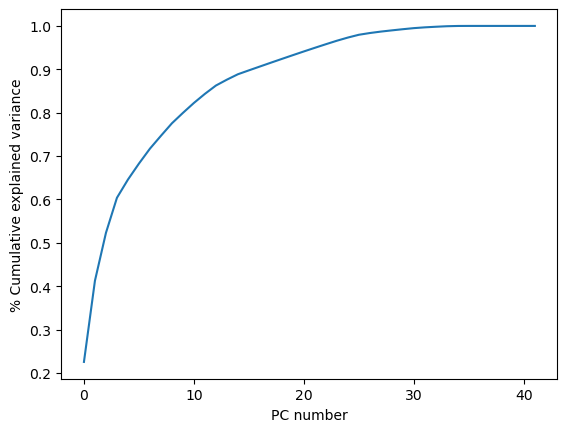

In [144]:
pca = PCA().set_output(transform="pandas")
pca.fit_transform(X) 

cum_explained_variance = np.cumsum(pca.explained_variance_ratio_)
plt.plot(cum_explained_variance)
plt.xlabel('PC number')
plt.ylabel('% Cumulative explained variance')

In [145]:
# From our cumulative explained variance 25 components captures 95% of the data

pca = PCA(n_components=25).set_output(transform="pandas")
df_pca = pca.fit_transform(X) #enconded and scaled data (that was passed into clustering algo)
df_pca.head()

,pca0,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9,...,pca15,pca16,pca17,pca18,pca19,pca20,pca21,pca22,pca23,pca24
0,0.462733,-0.673967,1.759102,0.372913,-0.395471,0.480429,0.219116,-0.601896,-0.688864,-0.590415,...,0.010222,0.682852,0.154701,-0.315865,-0.119747,-0.185136,0.060505,-0.084360,-0.012954,-0.141050
1,-1.315148,0.523485,1.726920,-0.319033,0.976420,-0.022113,-0.476920,-0.447331,-0.298576,0.041689,...,0.003723,0.687221,0.165801,-0.320340,-0.136017,-0.169437,0.068886,-0.081033,-0.009151,-0.149967
2,1.416709,-0.594779,1.720771,-0.162133,0.024513,-0.130612,-0.948895,-0.746927,0.590944,-0.091859,...,0.017431,0.679136,0.171960,-0.320698,-0.131554,-0.200337,0.057607,-0.092346,-0.015758,-0.157484
3,-1.621980,0.036292,1.376020,0.229735,0.450132,-0.218001,-0.214157,0.851257,0.017278,-0.267883,...,0.710155,-0.478800,-0.072579,-0.062007,-0.006915,-0.030773,0.014943,-0.028060,-0.011467,-0.120594
4,-0.954320,0.162719,1.426685,-0.424389,0.842566,-0.093131,0.050797,-0.080287,-0.551885,0.890872,...,-0.698762,-0.466102,-0.063226,-0.024292,-0.026177,-0.041637,0.019058,-0.059401,0.009562,-0.096179


In [147]:
# TRY to use PCA with models and compare the results with original features
df_pca.shape

(155904, 25)

### Feature Selection / Dimensionality Reduction

We need to apply different selection techniques to find out which one will be the best for our problems.

- Original Features vs. PCA conponents?

In [148]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold


In [149]:
# First model to test linear regression 

# Linear regression model for scaled dataset

# Separate the input features (X) and the target variable (y)
X = df_scaled_encoded[['avg_taxi_times_arr', 'avg_monthly_arr_delay', 'flight_distance_category_LONG','flight_distance_category_MEDIUM', 'flight_distance_category_SHORT','arr_hour', 'month_1','month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7','month_8', 'month_9', 'month_10', 'month_11', 'month_12','distance', 'air_time', 'traffic_Not Busy', 'traffic_Moderate', 'traffic_Busy', 'traffic_Very Busy', 'holiday']]
y = df_scaled_encoded['arr_delay']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a linear regression model
model = LinearRegression()

# Train the model using the training data
model.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = model.predict(X_test)

# Evaluate the model
score = model.score(X_test, y_test)

# Print the coefficient and intercept of the linear regression model
print('Coefficients:', model.coef_)
print('Intercept:', model.intercept_)
print('R^2 Score:', score)

Coefficients: [-5.73135326e-02 -4.78065605e+10  1.46253224e+11  1.46253224e+11
  1.46253224e+11  1.02096558e-01 -6.70494321e+10 -6.15672812e+09
 -7.82475227e+10 -5.56578233e+10 -1.73755064e+10  4.52402117e+10
  2.71204022e+10  3.08328004e+10 -9.69817296e+10 -7.67268848e+10
 -8.18725750e+10 -3.79713099e+10 -6.23928070e-01  6.14969254e-01
 -6.08726083e+10 -6.08726083e+10 -6.08726083e+10 -6.08726083e+10
  2.54645199e-02]
Intercept: -51355750604.272896
R^2 Score: 0.027416013798151284


In [150]:
# Try linear regression with more folds see if better results can be obtained

kf = KFold(n_splits=4, shuffle=True, random_state=42)  # Initialize KFold

# Separate the input features (X) and the target variable (y)
X = df_scaled_encoded[['avg_taxi_times_arr', 'avg_monthly_arr_delay', 'flight_distance_category_LONG',
                       'flight_distance_category_MEDIUM', 'flight_distance_category_SHORT', 'arr_hour', 'month_1',
                       'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9',
                       'month_10', 'month_11', 'month_12', 'distance', 'air_time', 'traffic_Not Busy',
                       'traffic_Moderate', 'traffic_Busy', 'traffic_Very Busy', 'holiday']]
y = df_scaled_encoded['arr_delay']

# Loop over the folds and train/evaluate the model on each fold
for fold_idx, (train_idx, test_idx) in enumerate(kf.split(X)):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Create a linear regression model
    model = LinearRegression()

    # Train the model using the training data
    model.fit(X_train, y_train)

    # Make predictions on the testing data
    y_pred = model.predict(X_test)

    # Evaluate the model on the testing set
    score = model.score(X_test, y_test)
    print(f"Fold {fold_idx}: R-squared = {score}")
    print("fold_idx:", fold_idx, '\n')

Fold 0: R-squared = 0.025392230926390424
fold_idx: 0 

Fold 1: R-squared = 0.02401308641785771
fold_idx: 1 

Fold 2: R-squared = 0.021473207316995757
fold_idx: 2 

Fold 3: R-squared = 0.02099977987774926
fold_idx: 3 



In [151]:
# Use Linear regression model for PCA data

# Separate the input features (X) and the target variable (y)
X = df_pca
y = df_scaled_encoded['arr_delay']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a linear regression model
model = LinearRegression()

# Train the model using the training data
model.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = model.predict(X_test)

# Evaluate the model
score = model.score(X_test, y_test)

# Print the coefficient and intercept of the linear regression model
print('Coefficients:', model.coef_)
print('Intercept:', model.intercept_)
print('R^2 Score:', score)

Coefficients: [-0.00174747  0.01486721  0.05825131  0.14831317 -0.02875311 -0.11375465
 -0.03909063 -0.04506228 -0.02892724 -0.00066927 -0.05918092  0.0711442
  0.02356847 -0.02193907 -0.00704061 -0.00290667  0.01466504 -0.00748486
 -0.00676707  0.00341929  0.00114713  0.00206746  0.01412844  0.00225833
 -0.00116854]
Intercept: 0.0002617007579922039
R^2 Score: 0.03174697124209935


In [152]:
# Try to use random forest regessor since our y prediction is a continous numeric value
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Separate the input features (X) and the target variable (y)
X = df_scaled_encoded[['avg_taxi_times_arr', 'avg_monthly_arr_delay', 'flight_distance_category_LONG','flight_distance_category_MEDIUM', 'flight_distance_category_SHORT','arr_hour', 'month_1','month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7','month_8', 'month_9', 'month_10', 'month_11', 'month_12','distance', 'air_time', 'traffic_Not Busy', 'traffic_Moderate', 'traffic_Busy', 'traffic_Very Busy', 'holiday']]
y = df_scaled_encoded['arr_delay']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Random Forest regressor model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model using the training data
rf_model.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = rf_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('Mean Squared Error:', mse)
print('R^2 Score:', r2)

Mean Squared Error: 0.996996375804514
R^2 Score: -0.12859902293624326


In [153]:
# applying ridge and lasso to see if theres an improvement  using unscaled data

from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# Separate the input features (X) and the target variable (y)
X = df_encoded[['avg_taxi_times_arr', 'avg_monthly_arr_delay', 'flight_distance_category_LONG','flight_distance_category_MEDIUM', 'flight_distance_category_SHORT','arr_hour', 'month_1','month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7','month_8', 'month_9', 'month_10', 'month_11', 'month_12','distance', 'air_time', 'traffic_Not Busy', 'traffic_Moderate', 'traffic_Busy', 'traffic_Very Busy', 'holiday']]
y = df_encoded['arr_delay']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create a Ridge regression model
ridge_model = Ridge(alpha=0.5)  # Adjust the regularization strength (alpha) as needed

# Train the Ridge model
ridge_model.fit(X_train_scaled, y_train)

# Make predictions using the Ridge model
y_pred_ridge = ridge_model.predict(X_test_scaled)

# Calculate evaluation metrics for Ridge model
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)

print('Ridge Regression:')
print('Mean Squared Error:', mse_ridge)
print('R^2 Score:', r2_ridge)

# Create a Lasso regression model
lasso_model = Lasso(alpha=0.1)  # Adjust the regularization strength (alpha) as needed

# Train the Lasso model
lasso_model.fit(X_train_scaled, y_train)

# Make predictions using the Lasso model
y_pred_lasso = lasso_model.predict(X_test_scaled)

# Calculate evaluation metrics for Lasso model
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
r2_lasso = r2_score(y_test, y_pred_lasso)

print('Lasso Regression:')
print('Mean Squared Error:', mse_lasso)
print('R^2 Score:', r2_lasso)

Ridge Regression:
Mean Squared Error: 2152.0750594570654
R^2 Score: 0.02760720262620664
Lasso Regression:
Mean Squared Error: 2154.1125471245628
R^2 Score: 0.02668658495355347


In [154]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold


# Split the data into target and independent variables
X = df_encoded[['avg_taxi_times_arr', 'avg_monthly_arr_delay', 'flight_distance_category_LONG','flight_distance_category_MEDIUM', 'flight_distance_category_SHORT','arr_hour', 'month_1','month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7','month_8', 'month_9', 'month_10', 'month_11', 'month_12','distance', 'air_time', 'traffic_Not Busy', 'traffic_Moderate', 'traffic_Busy', 'traffic_Very Busy', 'holiday']]
y = df_encoded['arr_delay']

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  # Initialize StratifiedKFold


# Split the data into target and independent variables
X = df_encoded[['avg_taxi_times_arr', 'avg_monthly_arr_delay', 'flight_distance_category_LONG', 'flight_distance_category_MEDIUM', 'flight_distance_category_SHORT', 'arr_hour', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'distance', 'air_time', 'traffic_Not Busy', 'traffic_Moderate', 'traffic_Busy', 'traffic_Very Busy', 'holiday']]
y = df_encoded['arr_delay']

log_reg = LogisticRegression()

# Loop over the folds and train/evaluate the model on each fold
for fold_idx, (train_idx, test_idx) in enumerate(skf.split(X, y)):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    # Train the model on the training set
    log_reg.fit(X_train, y_train)
    
    # Evaluate the model on the testing set
    score = log_reg.score(X_test, y_test)
    print(f"Fold {fold_idx}: accuracy = {score}")
    print("fold_idx:", fold_idx, '\n')
    

/Users/ckz/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/Users/ckz/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 0: accuracy = 0.030338988486578365
fold_idx: 0 



/Users/ckz/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 1: accuracy = 0.02979378467656586
fold_idx: 1 



/Users/ckz/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 2: accuracy = 0.029120297617138642
fold_idx: 2 



/Users/ckz/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 3: accuracy = 0.030338988486578365
fold_idx: 3 



/Users/ckz/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 4: accuracy = 0.029634381013470174
fold_idx: 4 



In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [155]:
## MULTINOMIAL LOGISTIC REGRESSION 
## Multinomial keeps crashing therefore will reduce the sample size in order to run

# # Shuffle the data in the DataFrame and create a sample with half the size
sample_size = len(df_encoded) // 10

df_encoded_s = df_encoded.sample(n=sample_size, random_state=42)

## Reset the index of the shuffled sample

flights_sample.reset_index(drop=True, inplace=True)
# Split the data into target and independent variables
X = df_encoded_s[['avg_taxi_times_arr', 'avg_monthly_arr_delay', 'flight_distance_category_LONG', 'flight_distance_category_MEDIUM', 'flight_distance_category_SHORT', 'arr_hour', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'distance', 'air_time', 'traffic_Not Busy', 'traffic_Moderate', 'traffic_Busy', 'traffic_Very Busy', 'holiday']]
y = df_encoded_s['arr_delay']

log_reg = LogisticRegression(multi_class='multinomial', solver='newton-cg')

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model on the training set
log_reg.fit(X_train, y_train)

# Evaluate the model on the testing set
y_pred = log_reg.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


/Users/ckz/anaconda3/lib/python3.10/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


NameError: name 'accuracy_score' is not defined

In [156]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [157]:
# Evaluate the model on the testing set
y_pred = log_reg.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.028864656831302116


In [158]:
import xgboost as xgb

In [159]:
# Create an XGBoost model
# Split the data into target and independent variables

X = df_scaled_encoded[['avg_taxi_times_arr', 'avg_monthly_arr_delay', 'flight_distance_category_LONG', 'flight_distance_category_MEDIUM', 'flight_distance_category_SHORT', 'arr_hour', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'distance', 'air_time', 'traffic_Not Busy', 'traffic_Moderate', 'traffic_Busy', 'traffic_Very Busy', 'holiday']]
y = df_scaled_encoded['arr_delay']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xgb_model = xgb.XGBRegressor()

xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)


mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean Squared Error:", mse)
print("R-squared:", r2)

Mean Squared Error: 0.8911645943949852
R-squared: -0.008797539206661709


### Modeling

Use different ML techniques to predict each problem.

- linear / logistic / multinomial logistic regression
- Naive Bayes
- Random Forest
- SVM
- XGBoost
- The ensemble of your own choice

In [160]:
### New feature added previous_weeks_delays to see if it results in better results


# Linear regression model for scaled dataset

# Separate the input features (X) and the target variable (y)
X = df_scaled_encoded2[['avg_taxi_times_arr', 'avg_monthly_arr_delay', 'flight_distance_category_LONG', 'flight_distance_category_MEDIUM', 'flight_distance_category_SHORT', 'arr_hour', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'distance', 'air_time', 'traffic_Not Busy', 'traffic_Moderate', 'traffic_Busy', 'traffic_Very Busy', 'holiday','prev_week_arr_delay']]
y = df_scaled_encoded2['arr_delay']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a linear regression model
model = LinearRegression()

# Train the model using the training data
model.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = model.predict(X_test)

# Evaluate the model
score = model.score(X_test, y_test)

# Print the coefficient and intercept of the linear regression model
print('Coefficients:', model.coef_)
print('Intercept:', model.intercept_)
print('R^2 Score:', score)

Coefficients: [-6.21893153e-02  5.91543770e-02 -1.45157033e+11 -1.45157033e+11
 -1.45157033e+11  1.02320782e-01  5.60319329e+11  5.60319329e+11
  5.60319329e+11  5.60319329e+11  5.60319329e+11  5.60319329e+11
  5.60319329e+11  5.60319329e+11  5.60319329e+11  5.60319329e+11
  5.60319329e+11  5.60319329e+11 -6.28683115e-01  6.11144755e-01
 -1.01880924e+12 -1.01880924e+12 -1.01880924e+12 -1.01880924e+12
  2.18115518e-02  5.94218303e-03]
Intercept: 603646942224.4802
R^2 Score: 0.022573285395666165


In [161]:
## Reduce the sample size see if it makes a difference

# # Shuffle the data in the DataFrame and create a sample with half the size
sample_size = len(df_scaled_encoded2) // 10

df_scaled_encoded3 = df_scaled_encoded2.sample(n=sample_size, random_state=42)

## Reset the index of the shuffled sample

df_scaled_encoded3.reset_index(drop=True, inplace=True)

In [162]:
df_scaled_encoded3.columns

Index(['avg_taxi_times_arr', 'avg_monthly_arr_delay', 'taxi_time', 'arr_hour',
       'distance', 'air_time', 'arr_delay', 'prev_week_arr_delay', 'fl_date',
       'holiday', 'mkt_unique_carrier_AA', 'mkt_unique_carrier_AS',
       'mkt_unique_carrier_B6', 'mkt_unique_carrier_DL',
       'mkt_unique_carrier_F9', 'mkt_unique_carrier_G4',
       'mkt_unique_carrier_HA', 'mkt_unique_carrier_NK',
       'mkt_unique_carrier_UA', 'mkt_unique_carrier_VX',
       'mkt_unique_carrier_WN', 'flight_distance_category_LONG',
       'flight_distance_category_MEDIUM', 'flight_distance_category_SHORT',
       'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
       'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12',
       'Region_Midwest', 'Region_North', 'Region_Other', 'Region_South',
       'Region_West', 'traffic_Not Busy', 'traffic_Moderate', 'traffic_Busy',
       'traffic_Very Busy'],
      dtype='object')

In [163]:
df_scaled_encoded3.shape

(15590, 45)

In [164]:
# Linear regression model for scaled dataset

# Separate the input features (X) and the target variable (y)
X = df_scaled_encoded3[['avg_taxi_times_arr', 'avg_monthly_arr_delay', 'flight_distance_category_LONG', 'flight_distance_category_MEDIUM', 'flight_distance_category_SHORT', 'arr_hour', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'distance', 'air_time', 'traffic_Not Busy', 'traffic_Moderate', 'traffic_Busy', 'traffic_Very Busy', 'holiday','prev_week_arr_delay']]
y = df_scaled_encoded3['arr_delay']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a linear regression model
model = LinearRegression()

# Train the model using the training data
model.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = model.predict(X_test)

# Evaluate the model
score = model.score(X_test, y_test)

# Print the coefficient and intercept of the linear regression model
print('Coefficients:', model.coef_)
print('Intercept:', model.intercept_)
print('R^2 Score:', score)

Coefficients: [-6.49103696e-02  4.77960563e-02  4.62561702e+11  4.62561702e+11
  4.62561702e+11  1.27460922e-01  8.86328822e+10  8.86328822e+10
  8.86328822e+10  8.86328822e+10  8.86328822e+10  8.86328822e+10
  8.86328822e+10  8.86328822e+10  8.86328822e+10  8.86328822e+10
  8.86328822e+10  8.86328822e+10 -5.74339351e-01  5.71250115e-01
  6.23556104e+11  6.23556104e+11  6.23556104e+11  6.23556104e+11
 -1.13968043e-01 -7.44926671e-04]
Intercept: -1174750687429.208
R^2 Score: 0.023605552351385062


### Evaluation

You have data from 2018 and 2019 to develop models. Use different evaluation metrics for each problem and compare the performance of different models.

You are required to predict delays on **out of sample** data from **first 7 days (1st-7th) of January 2020** and to share the file with LighthouseLabs. Sample submission can be found in the file **_sample_submission.csv_**

======================================================================
## Stretch Tasks

### Multiclass Classification

The target variables are **CARRIER_DELAY, WEATHER_DELAY, NAS_DELAY, SECURITY_DELAY, LATE_AIRCRAFT_DELAY**. We need to do additional transformations because these variables are not binary but continuos. For each flight that was delayed, we need to have one of these variables as 1 and others 0.

It can happen that we have two types of delays with more than 0 minutes. In this case, take the bigger one as 1 and others as 0.

### Binary Classification

The target variable is **CANCELLED**. The main problem here is going to be huge class imbalance. We have only very little cancelled flights with comparison to all flights. It is important to do the right sampling before training and to choose correct evaluation metrics.